In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')

from langchain_openai import ChatOpenAI

# Create the OpenAI LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0, streaming=True)

In [2]:
from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime
from sqlalchemy.orm import sessionmaker, declarative_base, Session
import datetime

# Database URL and Base declarative class
SQLALCHEMY_DATABASE_URL = 'sqlite:///./api_data.db'
Base = declarative_base()

# Define the ElectricityData model
class ElectricityData(Base):
    __tablename__ = 'electricity_prices'
    id = Column(Integer, primary_key=True, index=True)
    city = Column(String, index=True)
    state = Column(String, index=True)
    date_query = Column(String, index=True)
    region = Column(String, index=True)
    NOK_per_kWh = Column(Float)
    EUR_per_kWh = Column(Float)
    EXR = Column(Float)
    time_start = Column(String)
    time_end = Column(String)
    timestamp = Column(DateTime, default=datetime.datetime.now(datetime.UTC))

# Define the WeatherData model
class WeatherData(Base):
    __tablename__ = 'weather_data'
    id = Column(Integer, primary_key=True, index=True)
    city = Column(String, index=True)
    state = Column(String, index=True)
    date_query = Column(String)
    temperature = Column(Float)
    time_start = Column(String)
    time_end = Column(String)
    timestamp = Column(DateTime, default=datetime.datetime.now(datetime.UTC))

# Create the database and tables
def create_database():
    engine = create_engine(SQLALCHEMY_DATABASE_URL)
    Base.metadata.create_all(bind=engine)
    print("Database and tables created.")

# Drop all tables in the database
def reset_database():
    engine = create_engine(SQLALCHEMY_DATABASE_URL)
    Base.metadata.drop_all(bind=engine)
    Base.metadata.create_all(bind=engine)
    print("Database reset complete.")

# Get a new session for interacting with the database
def get_db():
    engine = create_engine(SQLALCHEMY_DATABASE_URL)
    SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
    try:
        db = SessionLocal()
        yield db
    finally:
        db.close()

#Function to store data
def store_data(db: Session, model, data: list):
    for item in data:
        db_item = model(**item)
        db.add(db_item)
    db.commit()

# Example usage to reset the database
if __name__ == "__main__":
    reset_database()  # Resets the database (drops and recreates tables)

Database reset complete.


In [3]:
# %%
# schemas.py
from pydantic import BaseModel, Field
from typing import List

class ElPriceResponse(BaseModel):
    NOK_per_kWh: float
    EUR_per_kWh: float
    EXR: float
    time_start: str
    time_end: str

    class Config:
        from_attributes = True

class ElPriceRequest(BaseModel):
    city: str = Field(description="City")
    state: str = Field(description="State or region")
    date_query: str = Field(description="Date query (e.g., 'today', 'yesterday', 'last 10 days', 'last 30 days', 'last three months', or 'YYYY-MM-DD/YYYY-MM-DD')")

# Pydantic models
class WeatherDataResponse(BaseModel):
    temperature: float
    time_start: str
    time_end: str

    class Config:
        from_attributes = True

class WeatherRequest(BaseModel):
    city: str = Field(description="City")
    state: str = Field(description="State or region")
    date_query: str = Field(description="Date query (e.g., 'today', 'yesterday', 'last 10 days', 'last 30 days', 'last three months', or 'YYYY-MM-DD/YYYY-MM-DD')")




# Models and other classes remain the same


# %% [markdown]
# ## Electricricty Price API

# Create the database tables
#Base.metadata.create_all(bind=engine)

from sqlalchemy.orm import Session
from pydantic import BaseModel, Field
from typing import List, Dict, Any, Optional
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from datetime import datetime, timedelta
import requests
import json
import requests_cache
from retry_requests import retry
import pandas as pd
import openmeteo_requests

# Assuming the database and models are already set up as in your original code.

# Tool to fetch electricity prices
class ElectricityPriceTool:
    REGIONS = {
        "NO1": ("Oslo", (59.9139, 10.7522)),
        "NO2": ("Kristiansand", (58.1467, 7.9956)),
        "NO3": ("Trondheim", (63.4305, 10.3951)),
        "NO4": ("Tromsø", (69.6492, 18.9553)),
        "NO5": ("Bergen", (60.3928, 5.3221)),
    }

    def __init__(self, db: Session):
        self.db = db

    def get_coordinates(self, city_name: str, state: str) -> Optional[tuple]:
        geolocator = Nominatim(user_agent="electricity_price_api")
        location = geolocator.geocode(f"{city_name}, {state}")
        if location:
            return location.latitude, location.longitude
        return None

    def find_nearest_region(self, lat: float, lon: float) -> Optional[str]:
        min_distance = float("inf")
        nearest_region = None
        for region, (city, coordinates) in self.REGIONS.items():
            distance = geodesic((lat, lon), coordinates).kilometers
            if distance < min_distance:
                min_distance = distance
                nearest_region = region
        return nearest_region

    def fetch_electricity_prices(self, year: str, month: str, day: str, region: str) -> list:
        url = f"https://www.hvakosterstrommen.no/api/v1/prices/{year}/{month}-{day}_{region}.json"
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        return {"error": f"Error fetching data: {response.status_code}"}

    def store_prices(self, request: Dict[str, Any], region: str, prices: list):
        data = [
            {
                "city": request['city'],
                "state": request['state'],
                "date_query": request['date_query'],
                "region": region,
                "NOK_per_kWh": price["NOK_per_kWh"],
                "EUR_per_kWh": price["EUR_per_kWh"],
                "EXR": price["EXR"],
                "time_start": price["time_start"],
                "time_end": price["time_end"]
            }
            for price in prices
        ]
        store_data(self.db, ElectricityData, data)  # Use the correct class name here

    def get_electricity_prices(self, request: Dict[str, Any]) -> List[Dict[str, Any]]:
        coordinates = self.get_coordinates(request['city'], request['state'])
        if not coordinates:
            return {"error": "City not found"}

        lat, lon = coordinates
        start_date, end_date = parse_date_query(request['date_query'])
        nearest_region = self.find_nearest_region(lat, lon)
        if nearest_region:
            prices = self.fetch_electricity_prices(start_date[:4], start_date[5:7], start_date[8:10], nearest_region)
            if isinstance(prices, list):
                self.store_prices(request, nearest_region, prices)
                return prices
            return prices  # Return the error message
        return {"error": "Could not determine the nearest region."}

# Tool to fetch and store weather data
class WeatherDataTool:

    def __init__(self, db: Session):
        self.db = db

    def store_weather_data(self, request: Dict[str, Any], observations: list):
        data = [
            {
                "city": request['city'],
                "state": request['state'],
                "date_query": request['date_query'],
                "temperature": observation['temperature'],
                "time_start": observation['time_start'],
                "time_end": observation['time_end'],
            }
            for observation in observations
        ]
        store_data(self.db, WeatherData, data)  # Use the correct class name here

    def get_weather_data(self, request: Dict[str, Any]) -> List[Dict[str, Any]]:
        coordinates = ElectricityPriceTool(self.db).get_coordinates(request['city'], request['state'])
        if not coordinates:
            return {"error": "Could not find coordinates for the specified city and state."}

        latitude, longitude = coordinates
        start_date, end_date = parse_date_query(request['date_query'])

        # Setup the Open-Meteo API client with cache and retry on error
        cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
        retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session)

        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": "temperature_2m"
        }
        responses = openmeteo.weather_api(url, params=params)

        # Process first location
        response = responses[0]

        # Process hourly data
        hourly = response.Hourly()
        hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

        hourly_dates = pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ).strftime('%Y-%m-%dT%H:%M:%S%z')

        # Create a list of dictionaries for each observation
        observations = []
        for i in range(len(hourly_dates) - 1):
            observations.append({
                "temperature": float(hourly_temperature_2m[i]),
                "time_start": hourly_dates[i],
                "time_end": hourly_dates[i + 1]
            })

        self.store_weather_data(request, observations)

        return observations

# Utility function to parse date queries
def parse_date_query(date_query: str) -> (str, str):
    today = datetime.utcnow().date()
    if date_query.lower() == 'today':
        start_date = end_date = today
    elif date_query.lower() == 'yesterday':
        start_date = end_date = today - timedelta(days=1)
    elif 'last' in date_query.lower():
        if "10 days" in date_query.lower():
            start_date = today - timedelta(10)
        elif "30 days" in date_query.lower():
            start_date = today - timedelta(30)
        elif "three months" in date_query.lower():
            start_date = today - timedelta(90)
        else:
            raise ValueError("Invalid date query")
        end_date = today
    elif '/' in date_query:
        start_date, end_date = date_query.split('/')
        start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
        end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
    else:
        raise ValueError("Invalid date_query format.")
    return start_date.isoformat(), end_date.isoformat()

In [4]:
from sqlalchemy import create_engine, event
from sqlalchemy.orm import sessionmaker, declarative_base, Session
from sqlalchemy.exc import NoResultFound

SQLALCHEMY_DATABASE_URL = 'sqlite:///./api_data.db'
Base = declarative_base()

# Custom session to handle API fetching if data is missing
class CustomSession(Session):
    def query_with_api(self, model, request):
        try:
            # Attempt to retrieve data from the database
            result = self.query(model).filter_by(**request).all()
            if result:
                return result
            else:
                raise NoResultFound
        except NoResultFound:
            # If data is not found, fetch from the API and store it
            if model == ElectricityData:
                tool = ElectricityPriceTool(self)
                tool.get_electricity_prices(request)
            elif model == WeatherData:
                tool = WeatherDataTool(self)
                tool.get_weather_data(request)
            # Attempt to retrieve data again after fetching from the API
            result = self.query(model).filter_by(**request).all()
            return result

def get_db():
    # Use the custom session
    engine = create_engine(SQLALCHEMY_DATABASE_URL)
    SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine, class_=CustomSession)
    try:
        db = SessionLocal()
        yield db
    finally:
        db.close()

# Other parts of your code (models, tools, etc.) remain unchanged

In [5]:
def get_all_electricity_prices(db: Session, request: Dict[str, Any]) -> List[ElPriceResponse]:
    prices = db.query_with_api(ElectricityData, request)
    return [ElPriceResponse.from_orm(price) for price in prices]

def get_all_weather_data(db: Session, request: Dict[str, Any]) -> List[WeatherDataResponse]:
    weather_data = db.query_with_api(WeatherData, request)
    return [WeatherDataResponse.from_orm(weather) for weather in weather_data]

In [6]:
# Example usage
db = next(get_db())

# Example request for electricity prices
electricity_request = {
    "city": "Lillehammer",
    "state": "Oslo",
    "date_query": "2024-01-01/2024-01-01"
}

# Retrieve all electricity prices with automatic API fetching if necessary
all_prices = get_all_electricity_prices(db, electricity_request)
print(all_prices)

# Example request for weather data
weather_request = {
    "city": "Lillehammer",
    "state": "",
    "date_query": "2024-01-01/2024-01-01"
}

# Retrieve all weather data with automatic API fetching if necessary
all_weather = get_all_weather_data(db, weather_request)
print(all_weather)

db.close()

[ElPriceResponse(NOK_per_kWh=0.60463, EUR_per_kWh=0.05379, EXR=11.2405, time_start='2024-01-01T00:00:00+01:00', time_end='2024-01-01T01:00:00+01:00'), ElPriceResponse(NOK_per_kWh=0.55056, EUR_per_kWh=0.04898, EXR=11.2405, time_start='2024-01-01T01:00:00+01:00', time_end='2024-01-01T02:00:00+01:00'), ElPriceResponse(NOK_per_kWh=0.30855, EUR_per_kWh=0.02745, EXR=11.2405, time_start='2024-01-01T02:00:00+01:00', time_end='2024-01-01T03:00:00+01:00'), ElPriceResponse(NOK_per_kWh=0.27517, EUR_per_kWh=0.02448, EXR=11.2405, time_start='2024-01-01T03:00:00+01:00', time_end='2024-01-01T04:00:00+01:00'), ElPriceResponse(NOK_per_kWh=0.26988, EUR_per_kWh=0.02401, EXR=11.2405, time_start='2024-01-01T04:00:00+01:00', time_end='2024-01-01T05:00:00+01:00'), ElPriceResponse(NOK_per_kWh=0.23864, EUR_per_kWh=0.02123, EXR=11.2405, time_start='2024-01-01T05:00:00+01:00', time_end='2024-01-01T06:00:00+01:00'), ElPriceResponse(NOK_per_kWh=0.25426, EUR_per_kWh=0.02262, EXR=11.2405, time_start='2024-01-01T06:00

In [7]:
from pydantic import BaseModel, Field

class ElectricityRequestInput(BaseModel):
    city: str = Field(description="City name")
    state: str = Field(description="State or region name")
    date_query: str = Field(description="Date query (e.g., 'YYYY-MM-DD/YYYY-MM-DD')")

class WeatherRequestInput(BaseModel):
    city: str = Field(description="City name")
    state: str = Field(description="State or region name")
    date_query: str = Field(description="Date query (e.g., 'YYYY-MM-DD/YYYY-MM-DD')")

def process_electricity_prices(prices: List[ElPriceResponse]):
    # Convert each ElPriceResponse to a dictionary
    return [price.dict() for price in prices]

def process_weather_data(data: List[WeatherDataResponse]) -> List[Dict[str, Any]]:
    # Convert each WeatherDataResponse to a dictionary
    return [item.dict() for item in data]

def query_electricity_prices(db: Session, city: str, state: str, date_query: str) -> List[Dict[str, Any]]:
    prices = get_all_electricity_prices(db, {"city": city, "state": state, "date_query": date_query})
    # Convert to a list of dictionaries
    return process_electricity_prices(prices)

def query_weather_data(db: Session, city: str, state: str, date_query: str) -> List[Dict[str, Any]]:
    request = {"city": city, "state": state, "date_query": date_query}
    weather_data = get_all_weather_data(db, request)
    return process_weather_data(weather_data)

In [8]:
from langchain_core.tools import StructuredTool

electricity_price_tool = StructuredTool.from_function(
    func=lambda city, state, date_query: query_electricity_prices(next(get_db()), city, state, date_query),
    name="ElectricityPriceTool",
    description="Fetches electricity prices for a given city, state, and date query.",
    args_schema=ElectricityRequestInput
)

weather_data_tool = StructuredTool.from_function(
    func=lambda city, state, date_query: query_weather_data(next(get_db()), city, state, date_query),
    name="WeatherDataTool",
    description="Fetches weather data for a given city, state, and date query.",
    args_schema=WeatherRequestInput
)



# Fishing tools (data retrieval)
fishing_tools = [electricity_price_tool, weather_data_tool]

# Bind fishing tools to LLM
llm_with_fishing_tools = llm.bind_tools(fishing_tools)

In [9]:
from langchain_core.tools import ToolException

def handle_tool_error(error: ToolException) -> str:
    return f"Error during tool execution: {error.args[0]} Please try again."

# Apply the error handler to the tools
electricity_price_tool.handle_tool_error = handle_tool_error
weather_data_tool.handle_tool_error = handle_tool_error

In [10]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase

engine = create_engine(SQLALCHEMY_DATABASE_URL)
db = SQLDatabase(engine)

# Assuming `db` is your database session and `llm` is your language model
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# SQL tools (data analysis)
sql_tools = toolkit.get_tools()

# Bind SQL tools to LLM
llm_with_sql_tools = llm.bind_tools(sql_tools)

In [27]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# Define the state structure
class State(TypedDict):
    messages: Annotated[list, add_messages]
    data_stored: bool
    analyzing_data: bool

# Initialize the state graph
graph_builder = StateGraph(State)

# Define the ToolNode to handle tool invocation
class ToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, llm_with_tools) -> None:
        self.llm_with_tools = llm_with_tools

    def __call__(self, state: State):
        if messages := state.get("messages", []):
            ai_message = messages[-1]
        else:
            raise ValueError("No message found in input")

        if not isinstance(ai_message, AIMessage):
            raise ValueError("The last message must be an AIMessage")

        outputs = []
        for tool_call in ai_message.tool_calls:
            # Invoke the tool and get the result
            tool_result = self.llm_with_tools.invoke(tool_call["args"])
            # Add the tool's response as a ToolMessage
            tool_message = ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            )
            outputs.append(tool_message)

        # Update the state with the tool response
        state["messages"].extend(outputs)
        return state

# Instantiate the tool nodes for both phases
store_data_tool_node = ToolNode(llm_with_fishing_tools)
analyze_data_tool_node = ToolNode(llm_with_sql_tools)

# Define the chatbot node
def chatbot(state: State):
    return {"messages": [llm_with_fishing_tools.invoke(state["messages"])]}

# Store data node with tool invocation
def store_data_node(state: State):
    # Invoke the fishing tools to retrieve and store data
    state = store_data_tool_node(state)
    state["data_stored"] = True
    return state

# Analyze data node with tool invocation
def analyze_data_node(state: State):
    # Use SQL tools to analyze the stored data
    state = analyze_data_tool_node(state)
    state["analyzing_data"] = True
    return state

# Add nodes to the graph before creating edges
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("store_data", store_data_node)
graph_builder.add_node("analyze_data", analyze_data_node)

# Routing logic to determine the next step
def route_logic(state: State) -> Literal["store_data", "analyze_data", "__end__"]:
    if not state.get("data_stored", False):
        return "store_data"
    elif not state.get("analyzing_data", False):
        return "analyze_data"
    else:
        return "__end__"

# Define the transitions after all nodes have been added
graph_builder.add_conditional_edges(
    "chatbot",
    route_logic,
    {"store_data": "store_data", "analyze_data": "analyze_data", "__end__": "__end__"},
)

# Ensure sequential flow from store_data to analyze_data
graph_builder.add_edge("store_data", "analyze_data")

# After analyzing data, return to chatbot or end
graph_builder.add_edge("analyze_data", "chatbot")

# Start with the chatbot
graph_builder.add_edge(START, "chatbot")

# Compile the graph
graph = graph_builder.compile()

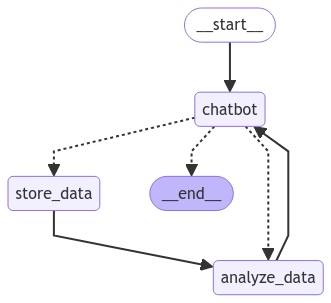

In [28]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
from langchain_core.messages import HumanMessage

In [32]:
from langchain_core.messages import HumanMessage

# User input message
user_input = "Can you retrieve electricity prices for yesterday in Lillehammer and find the average price using SQL tools?"
user_message = HumanMessage(content=user_input)

# Initial state of the graph
initial_state = {
    "messages": [user_message],  # List of messages starts with the user input
    "data_stored": False,        # Initially, no data is stored
    "analyzing_data": False      # Initially, no data is being analyzed
}

# Run the graph with the initial state
for event in graph.stream(initial_state):
    print(event)  # Debug: Inspect the event structure


{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_yf4aVMJD5eSFlWCpB30VDc1l', 'function': {'arguments': '{"city": "Lillehammer", "state": "Oppland", "date_query": "2022-10-24/2022-10-24"}', 'name': 'ElectricityPriceTool'}, 'type': 'function'}, {'index': 1, 'id': 'call_CsbkyPIumc86MDVS6SgtBh1M', 'function': {'arguments': '{"city": "Lillehammer", "state": "Oppland", "date_query": "2022-10-24/2022-10-24"}', 'name': 'ElectricityPriceTool'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-1106', 'system_fingerprint': 'fp_5aa43294a1'}, id='run-9ba11678-f18f-4a65-85be-5da880bd3427-0', tool_calls=[{'name': 'ElectricityPriceTool', 'args': {'city': 'Lillehammer', 'state': 'Oppland', 'date_query': '2022-10-24/2022-10-24'}, 'id': 'call_yf4aVMJD5eSFlWCpB30VDc1l', 'type': 'tool_call'}, {'name': 'ElectricityPriceTool', 'args': {'city': 'Lillehammer', 'state': 'Oppland', 'date_query': '2022-10

ValueError: Invalid input type <class 'dict'>. Must be a PromptValue, str, or list of BaseMessages.

In [15]:
from langchain_core.messages import HumanMessage

user_input = "Can you retrieve electricity prices for yesterday in Lillehammer and find the average price using SQL tools?"
user_message = HumanMessage(content=user_input)

for event in graph.stream({"messages": [user_message]}):
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

NameError: name 'BaseMessage' is not defined